<h2> Laboratory Session 6 Inverse Kinematics with Vision Sensor in CoppeliaSim with suction cup manipulator</h2>

<br>- Requires that the files 'sim.py', 'simConst.py', 'remoteapi.dll' be hosted in the same folder as this Jupyter notebook. It also requires using the attached scene: RobotScaraManIKCV.ttt where a Scara robot and a pre-programmed pneumatic actuator (suction cup) appear to pick up and drop elements.
<br>- You have these files in the folder attached to the session (laboratories6.zip)

<br>- Requires installing the CV libraries from Anaconda:

<br> From Anaconda Terminal:

<br>- Step 1 - installing OpenCV 
<br>pip install opencv-python
<br>python
<br>import cv2

<br>- Step 2 - Check 
<br>OpenCV Version 
<br>cv2.version 
<br>exit()

<br>If you fail, look  https://programarfacil.com/blog/vision-artificial/instalar-opencv-python-anaconda/

Bibliography used outlines in openCV
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html

About the openCV and Jupyter Notebooks windows problem:
https://medium.com/@mrdatainsight/how-to-use-opencv-imshow-in-a-jupyter-notebook-quick-tip-ce83fa32b5ad


#### Although I give you the already created scene of this robot, I show you how I added the image sensor and modified its properties:

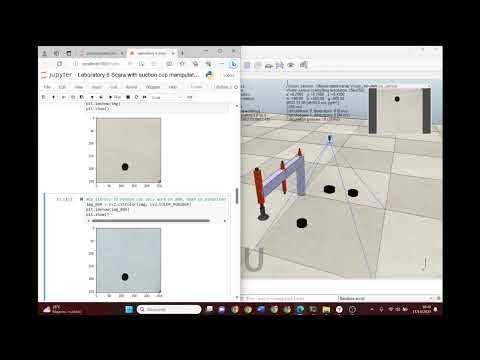

In [78]:
from IPython.display import YouTubeVideo

YouTubeVideo('unUjA_YVZnM')

<br><h4> Remember:</h4>
<br>1. Open the scene RobotScaraManIKCV.ttt
<br>2. Check that the camera can see the object when you press play, the Image Sensor can only see "renderable" objects.
<br>3. Remember that the Coppelia scene must be in PLAY to be controlled from Jupyter.


In [79]:
# we import the necessary libraries

import sympy as sp  

### 0. We establish the connection
We will use the functions of the COPPELIA Remote API.

In [80]:
import coppeliasim_zmqremoteapi_client
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np

def connect(port=23000):
    try:
        client = RemoteAPIClient('127.0.0.1', port)
        print(f"Connected to CoppeliaSim on port {port}")
        return client
    except Exception as e:
        print(f"Could not connect to CoppeliaSim on port {port}: {e}")
        return None

client = connect()
sim = client.getObject('sim')

Connected to CoppeliaSim on port 23000


<h3> 1. Suction cup control </h3>
Function that allows you to activate or deactivate the Coppelia suction cup from Jupyter. There are instructions in the Coppelia suctionPad scripts that allow remote use.

In [81]:
def setEffector(val):
    # function that triggers the end effector remotely
    # val is Int with value 0 or 1 to disable or activate the final actuator.
    # Get the script handle first
    script_handle = sim.getScript(sim.scripttype_childscript, 'suctionPad')
    res = sim.callScriptFunction('setEffector', script_handle, [val], [], [], [])
    return res

<h3> 2. We obtain the controllers (handlers) of the Joints, Suction Cup and Camera Sensor</h3>


In [82]:
# Get the handles for the joints, the suction cup and the camera sensor
suction = sim.getObject('/suctionPad')
sensorHandle = sim.getObject('/Vision_sensor')
joint1 = sim.getObject('/Joint1')
joint2 = sim.getObject('/Joint2')
joint3 = sim.getObject('/Joint3')
print(f"Handles - Suction: {suction}, Sensor: {sensorHandle}, Joints: {joint1}, {joint2}, {joint3}")

Handles - Suction: 22, Sensor: 29, Joints: 17, 19, 21


In [83]:
# Send positions to the joints, the first two in radians
q = [0.0, 0.0, -0.0]  # Home position and prism retracted (Suction Cup Up)

sim.setJointTargetPosition(joint1, float(q[0]))
sim.setJointTargetPosition(joint2, float(q[1]))
sim.setJointTargetPosition(joint3, float(q[2]))

1

In [84]:
# we deactivate the final actuator (suction cup)
setEffector(0)

([], {}, {}, '')

<h3> 3. We prepare the acquisition of the Image to obtain the coordinates of the piece and thus find a solution to the equations</h3>


In [85]:
import numpy as np
import sympy as sp
import cv2                      # opencv
import matplotlib.pyplot as plt # pyplot
from sympy import *
from sympy.physics.vector import init_vprinting

init_vprinting(use_latex='mathjax', pretty_print=False)
from sympy.physics.mechanics import dynamicsymbols
theta1, theta2, d3, lc, la, lb, theta, alpha, a, d = dynamicsymbols('theta1 theta2 d3 lc la lb theta alpha a d')
theta1, theta2, d3, lc, la, lb, theta, alpha, a, d 

(theta1, theta2, d3, lc, la, lb, theta, alpha, a, d)

In [86]:
# We obtain the image from the Camera Sensor
image = sim.getVisionSensorImg(sensorHandle)
resolution = sim.getVisionSensorRes(sensorHandle)
print(f"Image resolution: {resolution}")
len(image)

Image resolution: [256, 256]


2

In [87]:
resolution

[256, 256]

In [88]:
#It is an image with a resolution of 256*256 and each pixel is RGB
256*256*3

print(f"Image type: {type(image)}")
print(f"Resolution: {resolution}")

Image type: <class 'tuple'>
Resolution: [256, 256]


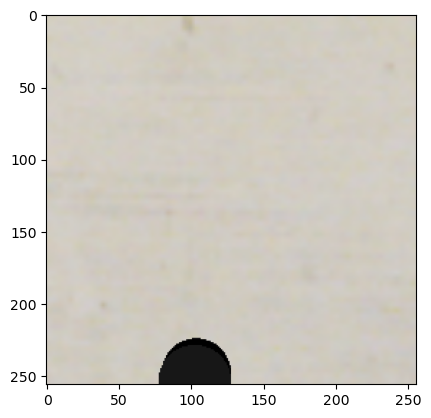

In [89]:
# Get image from vision sensor and convert to numpy array
img = np.frombuffer(image[0], dtype=np.uint8)  # The first element should be the image data
img = img.reshape(resolution[1], resolution[0], 3)  # Reshape to correct dimensions
plt.imshow(img)
plt.show()

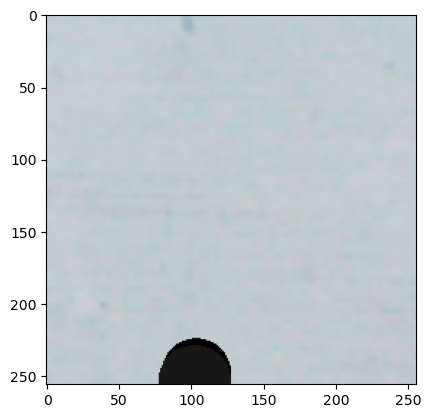

In [90]:
#CV library in Python can only work on BGR, GRAY or binarized images
img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img_BGR)
plt.show()

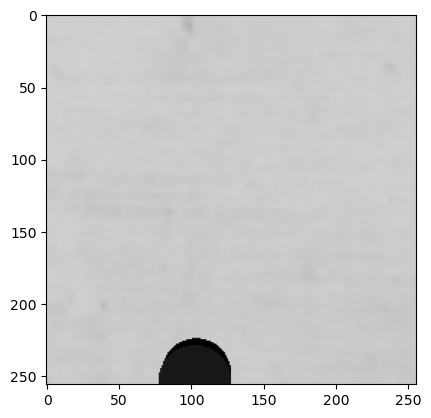

In [91]:
img_GRAY = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_GRAY, cmap='gray', vmin=0,vmax=255)
plt.show()

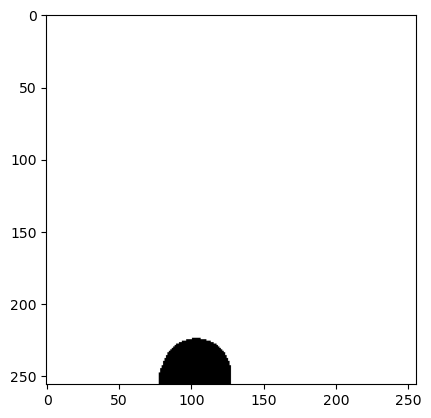

In [92]:
ret, thresh = cv2.threshold(img_GRAY,150,255,cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray', vmin=0,vmax=255)
plt.show()

In [93]:
#We can also use a function to automatically detect blobs directly with SimpleBlobDetector
# the BGR, GRAY or binarized image can be used directly

#def init_blob_detector():
# params = cv2.SimpleBlobDetector_Params()
# params.minThreshold = 1
# params.maxThreshold = 255
# params.filterByArea = True
# params.minArea = 1
# params.filterByCircularity = False
# params.filterByConvexity = False
# params.filterByInertia = False

detector=cv2.SimpleBlobDetector_create() #Verion antigua !!
keypoints=detector.detect(thresh)
print(keypoints)


()


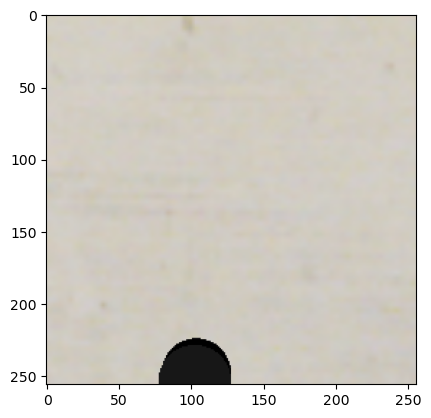

In [94]:
#image with blobs and marks
imagen_with_keypoints=cv2.drawKeypoints(img_BGR,keypoints,np.array([]),(0,0,255),cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#show image with keypoints
plt.imshow(cv2.cvtColor(imagen_with_keypoints,cv2.COLOR_BGR2RGB))


In [95]:
xi,yi,si=0,0,0
print ('blobs found:')
print (len(keypoints))



blobs found:
0


In [96]:
print ("   X     Y    AREA in the image")
for keyPoint in keypoints:
    if (keyPoint.size>10): #If the area of the object is greater than 10
        xi = N(keyPoint.pt[0],5)    
        yi = N(keyPoint.pt[1],5)
        si = N(keyPoint.size,5)
        print (xi,yi,si)

   X     Y    AREA in the image


In [97]:
 
print ("Position X,Y in the scene:")
x = N(0.5-xi*0.5/256,2)   
y = N(0.5-yi*0.5/256,2)
print (x,y)


Position X,Y in the scene:
0.50 0.50


In [98]:
z=0.021  #We mark the height to pick up the piece with the suction cup.
print(x,y,z)

0.50 0.50 0.021


In [99]:
# we prepare the equations by transforming the expressions (see exercise 7.1)
# from the form <expression = value> to the form <expression - value> = 0
eq1 = 0.2 * cos(theta1) + 0.2 * cos(theta1 + theta2) - x
eq2 = 0.2 * sin(theta1) + 0.2 * sin(theta1 + theta2) - y
eq3 = 0.105 - d3 - z

In [100]:
# We lowered the precision to 5 figures to make it easier for you to find the solution
try:
    q=nsolve((eq1,eq2,eq3),(theta1,theta2,d3),(1,1,1),prec=5)
except:
    print('No solution found')
    q=[0,0,0]
print(q)

No solution found
[0, 0, 0]


<h3> 4. We send previously calculated angles to each axis </h3>

In [101]:
# Set joint positions (first two in radians)
sim.setJointTargetPosition(joint1, float(q[0]))  # Pass data in radians
sim.setJointTargetPosition(joint2, float(q[1]))
sim.setJointTargetPosition(joint3, float(-q[2]))  # Note the negative value for joint3

1

In [102]:
# we activate the final actuator (suction cup)
setEffector(1)

([], {}, {}, '')

In [103]:
q[2] = 0.04  # Set the new position value
sim.setJointTargetPosition(joint3, float(-q[2])) 

1

<h3> 5. Build a sequence of movements </h3>

#### Using the procedure for calculating inverse kinematics and the time library, try to place the three existing objects on top of each other by size (from Largest to Smallest).


<br>- Note1: We can use the existing blob detection function to look at the Area of ​​each object and prepare the sequence
<br> You can also use other libraries or functions that you know about Computer Vision, this part is free
<br>- Note2: we can create the sequence by importing the time library and using time.sleep(time in seconds)
<br> import time
<br> time.sleep(1)


In [104]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import sympy as sp

# Symbolic variables for IK calculations
theta1, theta2, d3 = sp.symbols('theta1 theta2 d3')

In [105]:
def detect_and_sort_objects():
    # Set the vision sensor to a fixed absolute position and orientation
    fixed_position = [0, 0, 1]  # Fixed height of 1 meters
    sim.setObjectPosition(sensorHandle, -1, fixed_position)
    
    # Set a fixed perspective angle
    fixed_perspective_angle = 0.6  # About 34 degrees
    sim.setObjectFloatParameter(sensorHandle, sim.visionfloatparam_perspective_angle, fixed_perspective_angle)

    # Get image from vision sensor
    image = sim.getVisionSensorImg(sensorHandle)
    resolution = sim.getVisionSensorRes(sensorHandle)
    img = np.frombuffer(image[0], dtype=np.uint8)
    img = img.reshape(resolution[1], resolution[0], 3)
    
    # Process image
    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get object info with area filtering
    objects = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 300 < area < 700:  # Area range for discs
            M = cv2.moments(cnt)
            if M['m00'] != 0:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                objects.append({'area': area, 'center': (cx, cy)})
    
    # Sort objects by area (largest to smallest)
    objects.sort(key=lambda x: x['area'], reverse=True)
    return objects

Remember that you have to teach the professor how it works in the laboratory and each student must hand in this complete Jupyter notebook on the virtual campus.

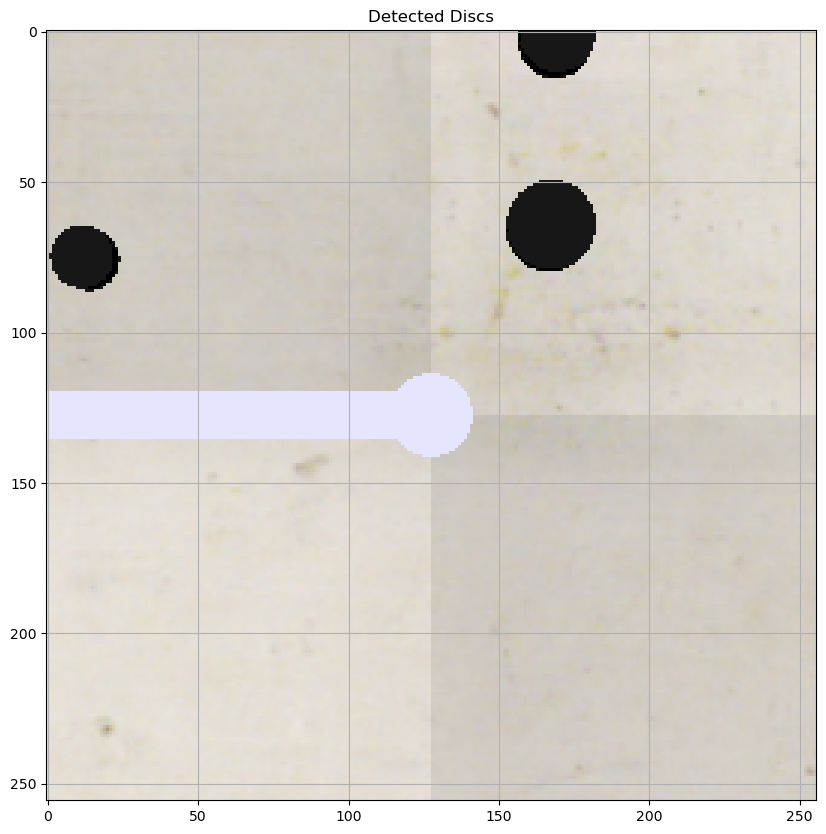

In [106]:
def visualize_detections(img, objects):
    # Convert to BGR for OpenCV drawing
    img_display = img.copy()
    
    # Draw detected objects
    for i, obj in enumerate(objects):
        # Get center coordinates
        cx, cy = obj['center']
        
        # Draw circle at center
        cv2.circle(img_display, (cx, cy), 3, (0, 255, 0), -1)
        
        # Draw contour circle approximating the disc
        radius = int(np.sqrt(obj['area']/np.pi))
        cv2.circle(img_display, (cx, cy), radius, (255, 0, 0), 2)
        
        # Add label
        label = f"Disc {i+1}: ({cx}, {cy})"
        cv2.putText(img_display, label, (cx-10, cy-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Display using matplotlib (better for notebooks than cv2.imshow)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.axis('on')
    plt.grid(True)
    plt.title('Detected Discs')
    plt.show()

# Test detection and visualization
objects = detect_and_sort_objects()
# Get the original image again for visualization
image = sim.getVisionSensorImg(sensorHandle)
resolution = sim.getVisionSensorRes(sensorHandle)
img = np.frombuffer(image[0], dtype=np.uint8)
img = img.reshape(resolution[1], resolution[0], 3)
img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Visualize detections
visualize_detections(img_BGR, objects)

In [107]:

cylinder0 = sim.getObject('/Cylinder0')  # Largest
cylinder1 = sim.getObject('/Cylinder1')  # Second largest
cylinder2 = sim.getObject('/Cylinder2')  # Smallest
   
# Get real positions
pos0_r = sim.getObjectPosition(cylinder0, -1)  # Largest
pos1_r = sim.getObjectPosition(cylinder1, -1)  # Second largest
pos2_r = sim.getObjectPosition(cylinder2, -1)  # Smallest
   


In [108]:
def calculate_ik(x, y):
    # Robot arm lengths
    l1 = 0.20  # First link length
    l2 = 0.20  # Second link length
    
    # Calculate theta2 first
    cos_theta2 = (x*x + y*y - l1*l1 - l2*l2)/(2*l1*l2)
    # Check if position is reachable
    if abs(cos_theta2) > 1:
        raise Exception("Position not reachable")
    
    # Use elbow-down configuration
    theta2 = -np.arccos(cos_theta2)  # Note the negative sign here!
    
    # Calculate theta1
    beta = np.arctan2(y, x)
    psi = np.arctan2(l2*np.sin(theta2), l1 + l2*cos_theta2)
    theta1 = beta - psi
    
    # Normalize angles to [-pi, pi]
    theta1 = np.mod(theta1 + np.pi, 2*np.pi) - np.pi
    theta2 = np.mod(theta2 + np.pi, 2*np.pi) - np.pi
    
    return float(theta1), float(theta2)

def move_robot(x, y, z=0.021, pick=True):
    try:
        # Use real coordinates directly (no conversion needed)
        print(f"Moving to position: x={x:.3f}, y={y:.3f}, z={z:.3f}")
        
        # Calculate joint angles
        theta1, theta2 = calculate_ik(x, y)
        
        # Move joints
        sim.setJointTargetPosition(joint1, theta1)
        sim.setJointTargetPosition(joint2, theta2)
        time.sleep(2)
        
        if pick:
            # Picking sequence
            sim.setJointTargetPosition(joint3, -z)
            time.sleep(1.5)
            setEffector(1)
            time.sleep(1)
            sim.setJointTargetPosition(joint3, 0)
            time.sleep(1.5)
        else:
            # Placing sequence
            sim.setJointTargetPosition(joint3, -z)
            time.sleep(1.5)
            setEffector(0)
            time.sleep(1)
            sim.setJointTargetPosition(joint3, 0)
            time.sleep(1.5)
            
    except Exception as e:
        print(f"Error in move_robot: {e}")

def move_to_home():
    print("Moving to home position...")
    sim.setJointTargetPosition(joint1, 0.0)
    sim.setJointTargetPosition(joint2, 0.0)
    sim.setJointTargetPosition(joint3, 0.0)
    time.sleep(2)

In [109]:

def stack_second_on_biggest():

    
    try:
        move_to_home()
        
        # Pick up second largest disc
        theta1, theta2 = calculate_ik(pos1_r[0], pos1_r[1])
        sim.setJointTargetPosition(joint1, theta1)
        sim.setJointTargetPosition(joint2, theta2)
        time.sleep(2)
        
        # Pick sequence
        sim.setJointTargetPosition(joint3, -0.105)
        time.sleep(1.5)
        setEffector(1)
        time.sleep(1)
        sim.setJointTargetPosition(joint3, 0)
        time.sleep(1.5)
        
        # Move to position above largest disc
        theta1, theta2 = calculate_ik(pos0_r[0], pos0_r[1])
        sim.setJointTargetPosition(joint1, theta1)
        sim.setJointTargetPosition(joint2, theta2)
        time.sleep(2)
        
        # Release sequence
        sim.setJointTargetPosition(joint3, -0.055)
        time.sleep(1.5)
        setEffector(0)
        time.sleep(1)
        sim.setJointTargetPosition(joint3, 0)
        time.sleep(1.5)
        
        move_to_home()
        
    except Exception as e:
        print(f"Error: {e}")
        move_to_home()

# Execute the stacking
stack_second_on_biggest()

Moving to home position...
Moving to home position...


In [110]:
# Continue stacking with third disc (using existing pos variable)
try:
    # Pick up smallest disc
    theta1, theta2 = calculate_ik(pos2_r[0], pos2_r[1])
    sim.setJointTargetPosition(joint1, theta1)
    sim.setJointTargetPosition(joint2, theta2)
    time.sleep(2)
    
    # Pick sequence
    sim.setJointTargetPosition(joint3, -0.105)
    time.sleep(1.5)
    setEffector(1)
    time.sleep(1)
    sim.setJointTargetPosition(joint3, 0)
    time.sleep(1.5)
    
    # Move to stack position (using pos0_r which we already have)
    theta1, theta2 = calculate_ik(pos0_r[0], pos0_r[1])
    sim.setJointTargetPosition(joint1, theta1)
    sim.setJointTargetPosition(joint2, theta2)
    time.sleep(2)
    
    # Release sequence at higher position
    sim.setJointTargetPosition(joint3, -0.035)
    time.sleep(1.5)
    setEffector(0)
    time.sleep(1)
    sim.setJointTargetPosition(joint3, 0)
    time.sleep(1.5)
    
except Exception as e:
    print(f"Error: {e}")